In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import dateutil.easter as easter
from lightgbm import LGBMRegressor
plt.style.use('ggplot')

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])
train.head()


,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [79]:
country = 'Poland'
store = 'KaggleMart'
product = 'Kaggle Advanced Techniques'
tmp = train[(train['country'] == country) & (train['store'] == store) & (train['product'] == product)]
tmp.index = tmp['date']

train_tmp = tmp[tmp.index.year < 2020]
test_tmp = tmp[tmp.index.year == 2020]

In [56]:
# # plot 
# tmp['num_sold'].plot(figsize=(15, 5), title='Sales of {} in {} in {}'.format(product, store, country))

In [57]:
# # seasonal decomposition
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition = seasonal_decompose(tmp['num_sold'], period=7)
# fig = plt.figure()
# fig = decomposition.plot()
# fig.set_size_inches(15, 8)


In [55]:
# # test for stationarity
# from statsmodels.tsa.stattools import adfuller
# def test_stationarity(timeseries):
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(window=7).mean()
#     rolstd = timeseries.rolling(window=7).std()

#     #Plot rolling statistics:
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
#     #Perform Dickey-Fuller test:
#     print ('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
# test_stationarity(tmp['num_sold'])

In [54]:
# # plot acf and pacf
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# fig, ax = plt.subplots(2, 1, figsize=(15, 8))
# plot_acf(train_tmp['num_sold'].diff().dropna(), lags=30, ax=ax[0])
# plot_pacf(train_tmp['num_sold'].diff().dropna(), lags=30, ax=ax[1])
# plt.show()

In [80]:
def feature_eng(df):

     dayofyear = df.index.dayofyear
     for k in range(1,2):
          df[f'sin'+str(k)] =np.sin(dayofyear/365*2*np.pi*k)
     easter_date = df['date'].apply(lambda date: pd.Timestamp(easter.easter(date.year)))
     df['easter'] = df.date.isin(easter_date).astype(int)
     return df
train_tmp_df = feature_eng(train_tmp)
test_tmp_df = feature_eng(test_tmp)
exog = ['sin1', 'easter']
test_tmp_df

/tmp/ipykernel_18841/385607955.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'sin'+str(k)] =np.sin(dayofyear/365*2*np.pi*k)
/tmp/ipykernel_18841/385607955.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['easter'] = df.date.isin(easter_date).astype(int)
/tmp/ipykernel_18841/385607955.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,row_id,date,country,store,product,num_sold,sin1,easter
date,,,,,,,,
2020-01-01,52592,2020-01-01,Poland,KaggleMart,Kaggle Advanced Techniques,193,1.721336e-02,0
2020-01-02,52640,2020-01-02,Poland,KaggleMart,Kaggle Advanced Techniques,462,3.442161e-02,0
2020-01-03,52688,2020-01-03,Poland,KaggleMart,Kaggle Advanced Techniques,467,5.161967e-02,0
2020-01-04,52736,2020-01-04,Poland,KaggleMart,Kaggle Advanced Techniques,486,6.880243e-02,0
2020-01-05,52784,2020-01-05,Poland,KaggleMart,Kaggle Advanced Techniques,514,8.596480e-02,0
...,...,...,...,...,...,...,...,...
2020-12-27,69920,2020-12-27,Poland,KaggleMart,Kaggle Advanced Techniques,622,-5.161967e-02,0
2020-12-28,69968,2020-12-28,Poland,KaggleMart,Kaggle Advanced Techniques,587,-3.442161e-02,0
2020-12-29,70016,2020-12-29,Poland,KaggleMart,Kaggle Advanced Techniques,674,-1.721336e-02,0


In [81]:
#
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_tmp_df['num_sold'], order=(1, 1, 3),seasonal_order=(1, 1, 1, 7),exog=train_tmp_df[exog].values)
model_fit = model.fit()


/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


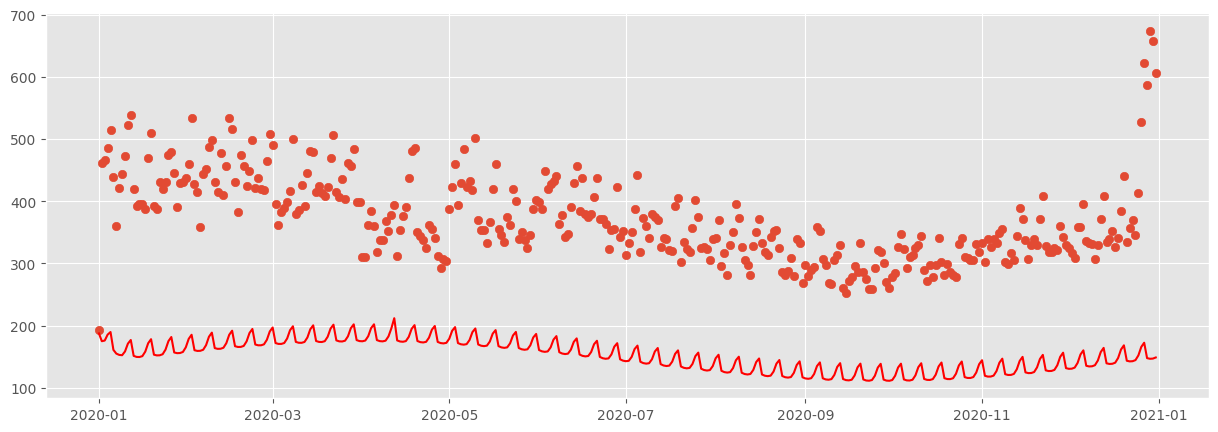

In [82]:
pred = model_fit.predict(start = len(train_tmp), end = len(train_tmp_df) + len(test_tmp_df) - 1, dynamic=False, exog=test_tmp_df[exog].values)
plt.figure(figsize=(15, 5))
plt.scatter(test_tmp.index, test_tmp['num_sold'], label='train')
plt.plot(pred, label='predicted', color='red')



In [58]:
# smape
smape(test_tmp['num_sold'], pred)


0.08314591890042937

In [43]:
# auto arima
from pmdarima import auto_arima
stepwise_model = auto_arima(train_tmp['num_sold'], exogenous=train_tmp[exog], start_p=1, start_q=1,
                            max_p=3, max_q=3, m=7,
                            start_P=0, seasonal=True,
                            max_P=3, max_Q=3, max_d=3, max_D=3,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=11030.681, Time=1.88 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11406.076, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10976.331, Time=1.32 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=11147.905, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11404.078, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=11392.714, Time=0.19 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=10839.905, Time=2.01 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=10756.570, Time=6.73 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : AIC=inf, Time=10.82 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=5.19 sec
 ARIMA(0,1,0)(3,0,0)[7] intercept   : AIC=10833.840, Time=2.18 sec
 ARIMA(2,1,0)(3,0,0)[7] intercept   : AIC=10750.819, Time=5.40 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=10835.353, Time=3.25 sec
 ARIMA(2,1,0)(3,0,1)[7] intercept   : AIC=inf, Time=9.49 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   